In [2]:
from sklearn.datasets import fetch_20newsgroups

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
import spacy
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pickle


from pyclustering.cluster.clarans import clarans
from pyclustering.utils import draw_clusters

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



ModuleNotFoundError: No module named 'pyclustering'

# reading data

In [14]:
data = pd.read_csv('./clustering/tweets2.csv')
data

,name,username,description,location,followers,numberstatuses,time,tweets
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...
...,...,...,...,...,...,...,...,...
17405,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:46,#Breaking\n#IslamicState \n#AmaqAgency \n\n#Fr...
17406,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:50,#Breaking\n\n Iraqi forces bulldozer destroyed...
17407,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:51,#Breaking \n#AmaqAgency \n#IslamicState \n\n#E...
17408,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 16:07,#PhotoReport \n#WilayatDimasiqh \n\n📷The Condu...


In [15]:
data = data["tweets"]
data

0        ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1        ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2        ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3        ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4        ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...
                               ...                        
17405    #Breaking\n#IslamicState \n#AmaqAgency \n\n#Fr...
17406    #Breaking\n\n Iraqi forces bulldozer destroyed...
17407    #Breaking \n#AmaqAgency \n#IslamicState \n\n#E...
17408    #PhotoReport \n#WilayatDimasiqh \n\n📷The Condu...
17409    #AmaqAgency Destroyed and burning Iraqi Forces...
Name: tweets, Length: 17410, dtype: object

# datacleaning

In [18]:
import re
import string

class text_cleaner():
    def __init__(self) -> None:
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.translator = str.maketrans('', '', string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()

    def clean(self,text):
        text = self.url_pattern.sub('', text)
        text = re.sub(r'@\w+', '', text)
        text = text.translate(self.translator)
        text = word_tokenize(text)
        text = [word for word in text if word.lower() not in stopwords.words("english")]
        text = [self.lemmatizer.lemmatize(word, pos='v') for word in text]
        text = [self.stemmer.stem(word) for word in text]

        return text

In [19]:
cleaner = text_cleaner()
data = data.apply(lambda x: cleaner.clean(x))


In [20]:
pickle.dump(data, open("./clustering/clean_data2.pkl", "wb"))

In [3]:
data = pickle.load(open("./clustering/clean_data2.pkl", "rb"))

In [236]:
data = pd.DataFrame(data)

In [237]:
data["len"] = data["tweets"].apply(lambda x: len(x))
data

data = data[data["len"] > 20]
data.shape

(247, 2)

# preparation

In [238]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=3)

vectorisationdata = [" ".join(text) for text in data["tweets"]]

tfidfdata = vectorizer.fit_transform(vectorisationdata)

In [249]:
n_components = 4
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
#The final X is the input which we will be using. 
# It has been cleaned, TF-IDF transformed, and its dimensions reduced.
clustringdata = lsa.fit_transform(tfidfdata)

# clustering

kmeans

In [256]:
minibatch = True
if minibatch:
   km = MiniBatchKMeans(n_clusters=3, init='k-means++', n_init=1,
   init_size=1000, batch_size=1000)
else:
   km = KMeans(n_clusters=3,init='k-means++', max_iter=100, n_init=1)
km.fit(clustringdata)


MiniBatchKMeans(batch_size=1000, init_size=1000, n_clusters=3, n_init=1)

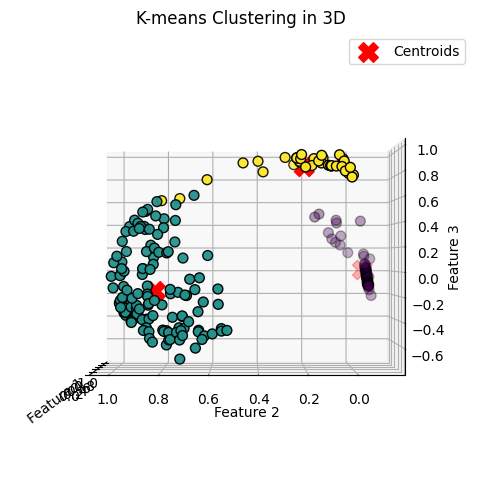

In [259]:
# Visualize the clusters in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(clustringdata[:, 0], clustringdata[:, 1], clustringdata[:, 2], c=km.labels_, cmap='viridis', edgecolor='k', s=50)

# Centroids
centers = km.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', marker='X', s=200, label='Centroids')

# Customize plot
ax.set_title('K-means Clustering in 3D')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()

ax.view_init(elev=0, azim=180)
plt.show()

CLARANS

In [260]:
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from pyclustering.cluster import cluster_visualizer_multidim

In [261]:
clarans_data = np.array(clustringdata).tolist()

In [262]:
cl = clarans(clarans_data, 3, 6, 4);
cl.process();

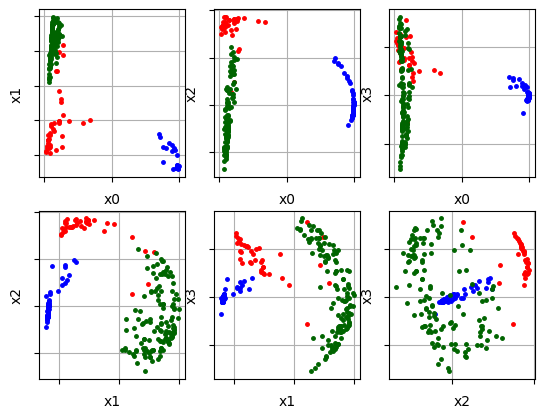

In [263]:
visualiz = cluster_visualizer_multidim()
visualiz.append_clusters(cl.get_clusters(), clarans_data)
visualiz.show(max_row_size=3)